Image Inpainting Project by :
- Varun MRN
- Tanay

We have imported libraries which help to implement neural networks and for visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms 
import torch.nn as nn  
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os
import seaborn as sns

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


converting into tensors

In [3]:
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Downloading datasets

In [4]:
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform_train)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform_test)

100%|██████████| 170498071/170498071 [00:02<00:00, 80050402.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
print(trainset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [6]:
print(testset)

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


creating batches

In [42]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

In [43]:
print(len(trainloader))

3125


creating iterators

In [44]:

dataiter = iter(trainloader)


images, labels = next(dataiter)

print(images.shape)
print(images[1].shape)
print(labels[1].item())


torch.Size([16, 3, 32, 32])
torch.Size([3, 32, 32])
9


In [45]:
img = images[1]
print(type(img))

<class 'torch.Tensor'>


In [46]:
npimg = img.numpy()
print(npimg.shape)
npimg = np.transpose(npimg, (1,2,0))
print(npimg.shape)

(3, 32, 32)
(32, 32, 3)


In [50]:
batch_size = 16

In [51]:
def imshow(img, title):
  npimg = img.numpy() / 2 + 0.5
  plt.figure(figsize = (batch_size, 1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(title)
  plt.show()

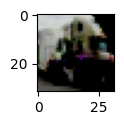

In [52]:
plt.figure(figsize = (1,1))
plt.imshow(npimg)
plt.show()

In [53]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title = [str(x.item()) for x in labels])

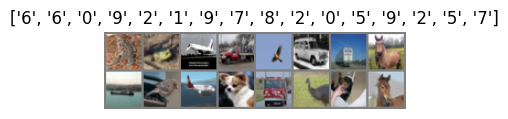

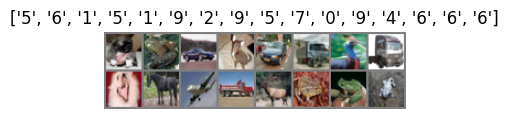

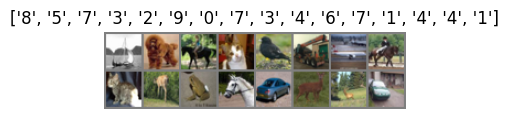

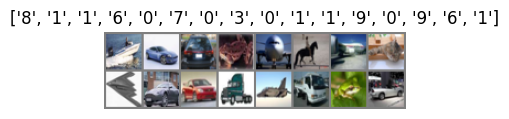

In [54]:
for i in range(4):
  show_batch_images(trainloader)

Data Pre Proccessing

In [56]:
image_dims = (32, 32)
batch_size = 16

In [57]:
def imshow_masked(img):
  npimg = img.numpy()
  plt.figure(figsize = (3, 3))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

creating dataset class where all the functions, attributes of a dataset is stored

here we are also creating mask by using cv.line() ,by taking random co-ordinates,random thickness,after that make the original image into corrupted by just dot product of original image's pixels to its corresponding pixels in the mask generated

In [58]:
class Dataset(torchvision.datasets.CIFAR10):
  def __init__(self, path, image_dims = (32, 32), n_channels = 3, train = True):
    super().__init__(path, train, download = True)
    self.n_classes = 10
    self.image_dims = image_dims
    self.n_channels = n_channels
    self.resize = transforms.Resize(image_dims)
    self.to_tensor = transforms.ToTensor()

  def __getitem__(self, index):
    image, label = super().__getitem__(index)

    Y_output = self.resize(image)
    X_input, X_mask = self.Create_Mask(Y_output)
    return self.to_tensor(X_input), self.to_tensor(X_mask), self.to_tensor(Y_output)

  def Create_Mask(self, image):
    mask = np.full((self.image_dims[0], self.image_dims[1], self.n_channels), 255, dtype = np.uint8)

    for _ in range(np.random.randint(1, 10)):
      x1, x2 = np.random.randint(1, self.image_dims[0]), np.random.randint(1, self.image_dims[0])
      y1, y2 = np.random.randint(1, self.image_dims[1]), np.random.randint(1, self.image_dims[1])
      thickness = np.random.randint(1, 3)

      cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

    image = np.asarray(image)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image, mask

In [59]:
Trainset = Dataset('./data', image_dims)
Testset = Dataset('./data', image_dims, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [60]:
Trainloader = torch.utils.data.DataLoader(Trainset, batch_size = batch_size, shuffle = True)
Testloader = torch.utils.data.DataLoader(Testset, batch_size = batch_size, shuffle = False)

In [61]:
Train_dataiter = iter(Trainloader)

In [62]:
Test_dataiter = iter(Testloader)

In [63]:

Train_dataiter = iter(Train_dataiter)

X_in, X_mask, Y_out = next(Train_dataiter)

print(X_in.shape, X_mask.shape, Y_out.shape)


torch.Size([16, 3, 32, 32]) torch.Size([16, 3, 32, 32]) torch.Size([16, 3, 32, 32])


Masked Image


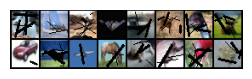

Masking Pattern


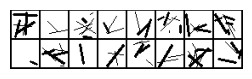

Original Image


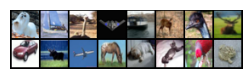

In [64]:
print('Masked Image')
imshow_masked(torchvision.utils.make_grid(X_in))
print('Masking Pattern')
imshow_masked(torchvision.utils.make_grid(X_mask))
print('Original Image')
imshow_masked(torchvision.utils.make_grid(Y_out))

Training

In Partial Convolutions, the kernel operates only on valid pixels, ignoring the masked regions. However:

When the number of valid pixels is small, the convolution result might have a lower magnitude because fewer values contribute.
To avoid underestimating or biasing the output in such cases, the result is scaled up by the mask ratio, compensating for the reduced contribution.


In [65]:
class PartialConv(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size, strides=1, padding=0, dilation=1, groups=1, bias=True):
        super(PartialConv, self).__init__()

        padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        self.input_conv = nn.Conv2d(in_filters, out_filters, kernel_size, strides, padding, bias=bias)
        self.mask_conv = nn.Conv2d(in_filters, out_filters, kernel_size, strides, padding, bias=False)
        
        self.window_size = kernel_size[0] * kernel_size[1]

        nn.init.constant_(self.mask_conv.weight, 1.0)

        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self, input, mask):
        output = self.input_conv(input * mask)
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        mask_ratio = self.window_size / (output_mask + 1e-8)

        output_mask = torch.clamp(output_mask, 0, 1)
  
        mask_ratio = mask_ratio * output_mask

        output = output * mask_ratio

        output = output + output_bias

        return output, output_mask

In strides = 2 , it takes 2 steps leaving the immediate next. also it downsamples the image.

In [66]:
class EncoderLayer(nn.Module):
    def __init__(self, in_filters, out_filters):
        super(EncoderLayer, self).__init__()
        self.p_conv_1 = PartialConv(in_filters, out_filters, (3, 3), strides=1)
        self.act_1 = nn.ReLU()
        self.p_conv_2 = PartialConv(out_filters, out_filters, (3, 3), strides=2)
        self.act_2 = nn.ReLU()

    def forward(self, inputs, masks):
        conv_out_1, mask_out_1 = self.p_conv_1(inputs, masks)
        conv_out_1 = self.act_1(conv_out_1)

        conv_out_2, mask_out_2 = self.p_conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(conv_out_2)

        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [67]:
class DecoderLayer(nn.Module):
    def __init__(self, in_filters_1, in_filters_2):
        super(DecoderLayer, self).__init__()

        self.up_image = nn.Upsample(scale_factor=(2, 2))
        self.up_mask = nn.Upsample(scale_factor=(2, 2))
        
        self.p_conv_1 = PartialConv(in_filters_1 * 2, in_filters_1, (3, 3))
        self.act_1 = nn.LeakyReLU(negative_slope=0.2)
        self.p_conv_2 = PartialConv(in_filters_1, in_filters_2, (3, 3))
        self.act_2 = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, in_image, in_mask, share_image, share_mask):
        up_out = self.up_image(in_image)
        mask_out = self.up_mask(in_mask)

        concat_image = torch.cat([share_image, up_out], axis=1)
        concat_mask = torch.cat([share_mask, mask_out], axis=1)

        conv_out_1, mask_out_1 = self.p_conv_1(concat_image, concat_mask)
        conv_out_1 = self.act_1(conv_out_1)
    
        conv_out_2, mask_out_2 = self.p_conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(conv_out_2)

        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [68]:
class InpaintingModel(nn.Module):
    def __init__(self, input_dims=(32, 32), num_channels=3):
        super(InpaintingModel, self).__init__()

        self.encoder_1 = EncoderLayer(num_channels, 32)
        self.encoder_2 = EncoderLayer(32, 64)
        self.encoder_3 = EncoderLayer(64, 128)
        self.encoder_4 = EncoderLayer(128, 256)

        self.decoder_1 = DecoderLayer(256, 128)
        self.decoder_2 = DecoderLayer(128, 64)
        self.decoder_3 = DecoderLayer(64, 32)
        self.decoder_4 = DecoderLayer(32, 3)

        self.output_layer = nn.Sequential(
            nn.Conv2d(3, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )

    def forward(self, inputs, masks):
        conv_out_1, mask_out_1, conv_out_2, mask_out_2 = self.encoder_1(inputs, masks)
        conv_out_3, mask_out_3, conv_out_4, mask_out_4 = self.encoder_2(conv_out_2, mask_out_2)
        conv_out_5, mask_out_5, conv_out_6, mask_out_6 = self.encoder_3(conv_out_4, mask_out_4)
        conv_out_7, mask_out_7, conv_out_8, mask_out_8 = self.encoder_4(conv_out_6, mask_out_6)

        conv_out_9, mask_out_9, conv_out_10, mask_out_10 = self.decoder_1(conv_out_8, mask_out_8, conv_out_7, mask_out_7)
        conv_out_11, mask_out_11, conv_out_12, mask_out_12 = self.decoder_2(conv_out_6, mask_out_6, conv_out_5, mask_out_5)
        conv_out_13, mask_out_13, conv_out_14, mask_out_14 = self.decoder_3(conv_out_4, mask_out_4, conv_out_3, mask_out_3)
        conv_out_15, mask_out_15, conv_out_16, mask_out_16 = self.decoder_4(conv_out_2, mask_out_2, conv_out_1, mask_out_1)

        outputs = self.output_layer(conv_out_16)
        return outputs

In [69]:
def jaccard_coeff(dataloader):
  for (X_input, X_mask, Y_output) in dataloader:
    X_input, X_mask, Y_output = X_input.to(device), X_mask.to(device), Y_output.to(device)
    outputs = model(X_input, X_mask)
    eps = 1e-15
    outputs = outputs.view(-1)
    Y_output = Y_output.view(-1)
    intersection = (outputs * Y_output).sum()
    union = (outputs.sum() + Y_output.sum()) - intersection
  return (intersection / (union + eps))

In [70]:
model = InpaintingModel()
model = model.to(device)

loss is mean squared error

optimizer used is adam optimizer

In [71]:
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters())

Min loss 0.00
Iteration: 0/3125, Loss: 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Min loss 0.00
Iteration: 100/3125, Loss: 0.00
Iteration: 200/3125, Loss: 0.00
Iteration: 300/3125, Loss: 0.00
Min loss 0.00
Iteration: 400/3125, Loss: 0.00
Iteration: 500/3125, Loss: 0.00
Iteration: 600/3125, Loss: 0.00
Min loss 0.00
Iteration: 700/3125, Loss: 0.00
Iteration: 800/3125, Loss: 0.00
Iteration: 900/3125, Loss: 0.00
Iteration: 1000/3125, Loss: 0.00
Iteration: 1100/3125, Loss: 0.00
Iteration: 1200/3125, Loss: 0.00
Min loss 0.00
Iteration: 1300/3125, Loss: 0.00
Iteration: 1400/3125, Loss: 0.00
Iteration: 1500/3125, Loss: 0.00
Iteration: 1600/3125, Loss: 0.00
Min loss 0.00
Iteration: 1700/3125, Loss: 0.00
Iteration: 1800/3125, Loss: 0.00
Iteration: 1900/3125, Loss: 0.00
Iteration: 2000/3125, Loss: 0.00
Iteration: 2100/3125, Loss: 0.00
Iteration: 2200/3125, Loss: 0.00
Iteration: 2300/3125, Loss: 0.00
Iteration: 2400/3125, Loss: 0.00
Iteration: 2500/3125, Loss: 0.00


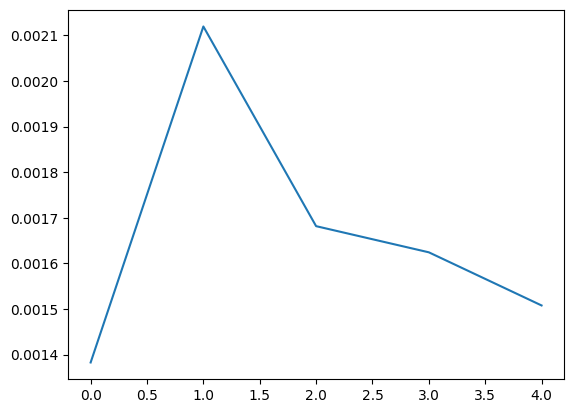

CPU times: user 3min 48s, sys: 38.5 s, total: 4min 27s
Wall time: 4min 26s


In [90]:
%%time
loss_epoch_arr = []
max_epochs = 5

min_loss = 1000

n_iters = np.ceil(50000/batch_size)
for epoch in range(max_epochs):
    model.train()                               
    for i, (X_input, X_mask, Y_output) in enumerate(Trainloader, 0):

        X_input, X_mask, Y_output = X_input.to(device), X_mask.to(device), Y_output.to(device)

        opt.zero_grad()

        outputs = model(X_input, X_mask)
        loss = loss_fn(Y_output, outputs)
        loss.backward()

        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.002f' % (i, n_iters, loss.item()))
            
        del X_input, X_mask, Y_output
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
plt.plot(loss_epoch_arr)
plt.show()

In [91]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [92]:
print(model)

InpaintingModel(
  (encoder_1): EncoderLayer(
    (p_conv_1): PartialConv(
      (input_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (mask_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (act_1): ReLU()
    (p_conv_2): PartialConv(
      (input_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (mask_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (act_2): ReLU()
  )
  (encoder_2): EncoderLayer(
    (p_conv_1): PartialConv(
      (input_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (mask_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (act_1): ReLU()
    (p_conv_2): PartialConv(
      (input_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (mask_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fals

In [93]:
weight_layer0 = list(model.parameters())[0].cpu()
weight_layer0 = weight_layer0.data.numpy()

In [94]:
print(weight_layer0.shape)

(32, 3, 3, 3)


/tmp/ipykernel_30/3685720747.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(weight_layer0.ravel())
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[]

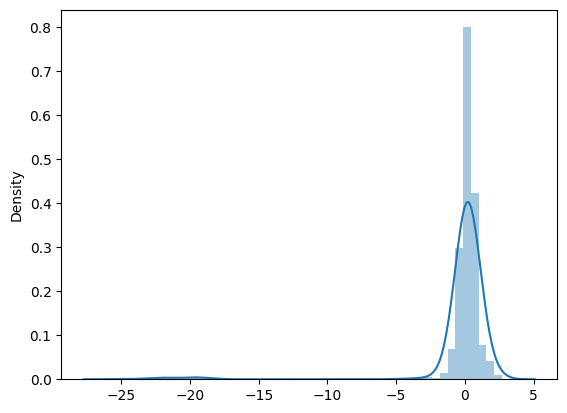

In [95]:
sns.distplot(weight_layer0.ravel())
plt.plot()

In [98]:

jaccard_index = jaccard_coeff(Testloader)

# Print the result
print(f"Jaccard Coefficient: {jaccard_index.item():.4f}")


Jaccard Coefficient: 0.4404


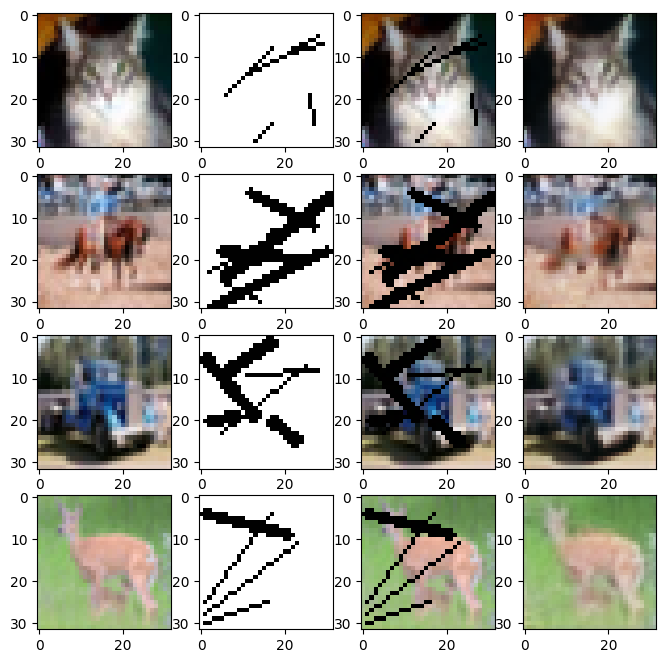

In [96]:

sample_inputs, sample_masks, sample_truths = next(Train_dataiter)
sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Move data back to CPU for visualization
sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i], (1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))


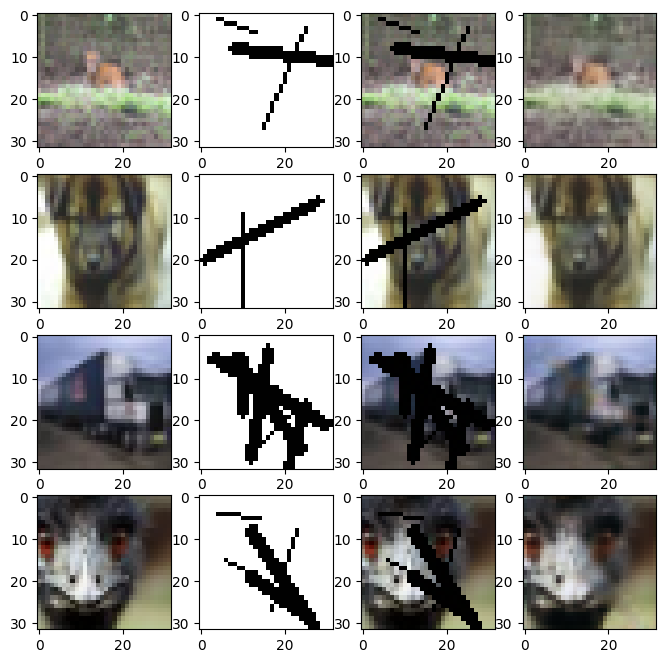

In [97]:

sample_inputs, sample_masks, sample_truths = next(Test_dataiter)
sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Move data back to CPU for visualization
sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i], (1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))
